# Data Science Bowl 2017

Code referenced from 
https://www.kaggle.com/ankasor/data-science-bowl-2017/improved-lung-segmentation-using-watershed
https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial


In [110]:
%cd Desktop/kaggle/sample_images

C:\Users\Angat\Desktop\kaggle\sample_images


In [208]:
for d in os.listdir(INPUT_FOLDER):
    print("Patient '{}' has {} scans".format(d, len(os.listdir(INPUT_FOLDER + d))))

Patient '00cba091fa4ad62cc3200a657aeb957e' has 134 scans
Patient '0a099f2549429d29b32f349e95fb2244' has 128 scans
Patient '0a0c32c9e08cc2ea76a71649de56be6d' has 133 scans
Patient '0a38e7597ca26f9374f8ea2770ba870d' has 110 scans
Patient '0acbebb8d463b4b9ca88cf38431aac69' has 203 scans
Patient '0b20184e0cd497028bdd155d9fb42dc9' has 196 scans
Patient '0bd0e3056cbf23a1cb7f0f0b18446068' has 280 scans
Patient '0c0de3749d4fe175b7a5098b060982a1' has 123 scans
Patient '0c37613214faddf8701ca41e6d43f56e' has 164 scans
Patient '0c59313f52304e25d5a7dcf9877633b1' has 244 scans
Patient '0c60f4b87afcb3e2dfa65abbbf3ef2f9' has 136 scans
Patient '0c98fcb55e3f36d0c2b6507f62f4c5f1' has 180 scans
Patient '0c9d8314f9c69840e25febabb1229fa4' has 221 scans
Patient '0ca943d821204ceb089510f836a367fd' has 147 scans
Patient '0d06d764d3c07572074d468b4cff954f' has 435 scans
Patient '0d19f1c627df49eb223771c28548350e' has 183 scans
Patient '0d2fcf787026fece4e57be167d079383' has 126 scans
Patient '0d941a3ad6c889ac451caf

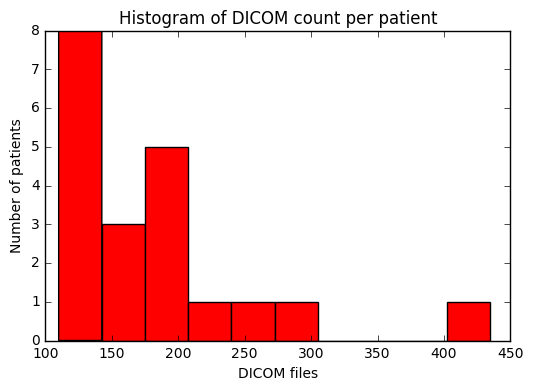

In [211]:
patient_sizes = [len(os.listdir(INPUT_FOLDER + d)) for d in os.listdir(INPUT_FOLDER)]
plt.hist(patient_sizes, color='red')
plt.ylabel('Number of patients')
plt.xlabel('DICOM files')
plt.title('Histogram of DICOM count per patient')

In [212]:
lables = pd.read_csv('C:/Users/Angat/Desktop/kaggle/stage1_labels.csv/stage1_labels.csv')

patients = pd.DataFrame(patients)

x = pd.concat((patients, lables), axis = 1, join='inner')
x = x.drop(0, axis=1)
x

,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1
5,0092c13f9e00a3717fdc940641f00015,0
6,00986bebc45e12038ef0ce3e9962b51a,0
7,00cba091fa4ad62cc3200a657aeb957e,0
8,00edff4f51a893d80dae2d42a7f45ad1,1
9,0121c2845f2b7df060945b072b2515d7,0


In [195]:
#Import all necessary packages
import pandas as pd
import numpy as np
import dicom
import os
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [196]:
#set input folder
INPUT_FOLDER = 'C:/Users/Angat/Desktop/kaggle/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
INPUT_FOLDER

'C:/Users/Angat/Desktop/kaggle/sample_images/'

In [197]:
%matplotlib inline


# Loading scans by slice
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Internal Marker


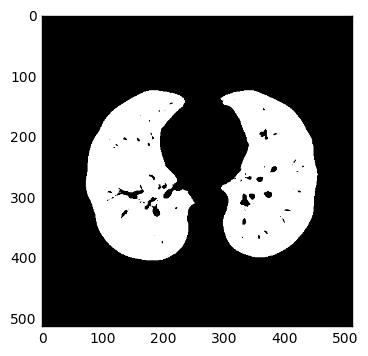

External Marker


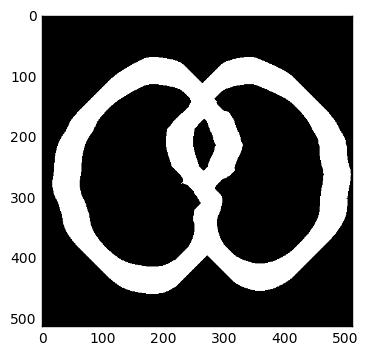

Watershed Marker


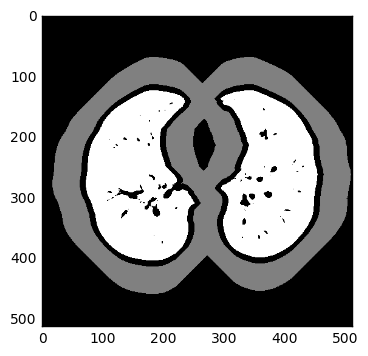

In [198]:
## Watershed

def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[65])
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

In [200]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

In [141]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing
'''
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)'''

'\npix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])\nprint("Shape before resampling\t", first_patient_pixels.shape)\nprint("Shape after resampling\t", pix_resampled.shape)'

In [154]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

128
Sobel Gradient


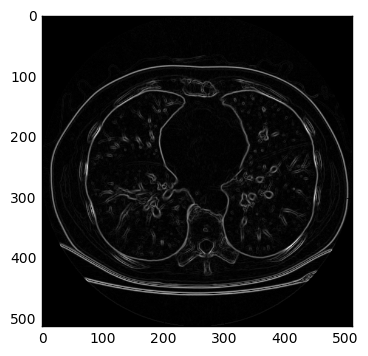

Watershed Image


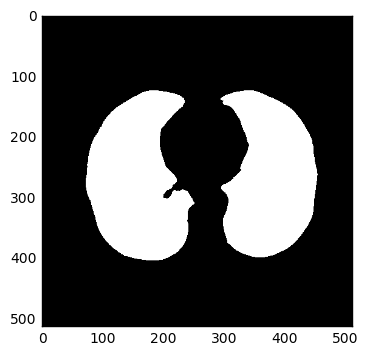

Outline after reinclusion


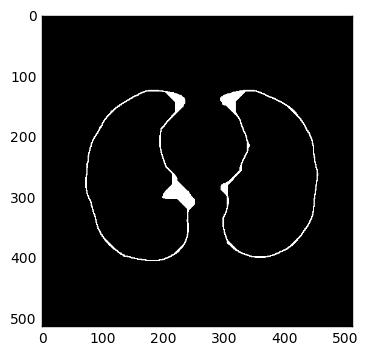

Lungfilter after closing


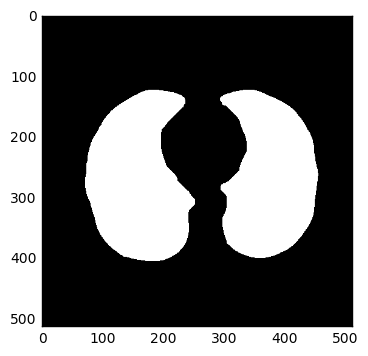

Segmented Lung


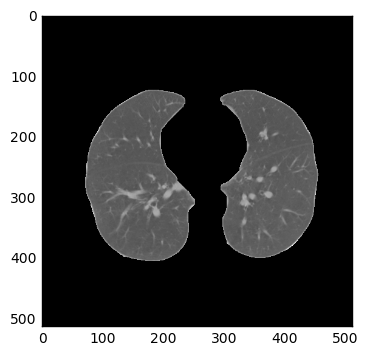

133
Sobel Gradient


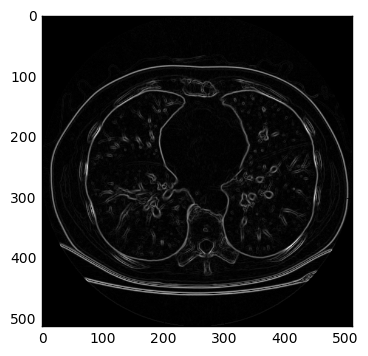

Watershed Image


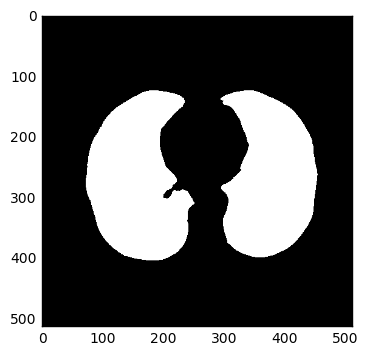

Outline after reinclusion


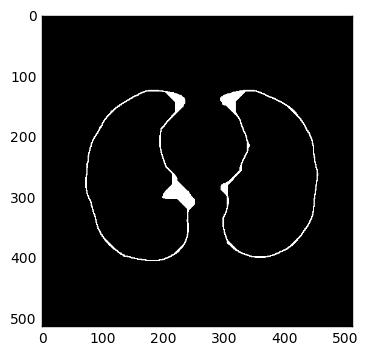

Lungfilter after closing


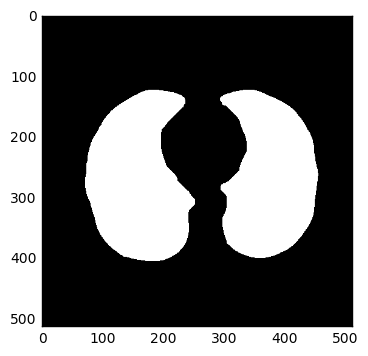

Segmented Lung


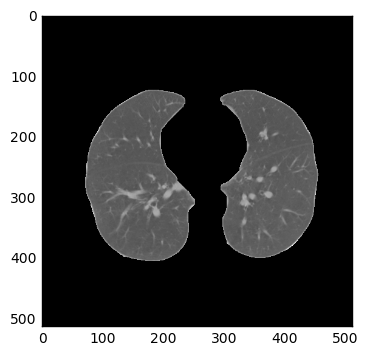

In [202]:
x = []
for i in range(1, 3):
    indv = load_scan(INPUT_FOLDER + patients[i])
    indv_pixels = get_pixels_hu(indv)
    print(len(indv_pixels))
    segment = seperate_lungs(indv_pixels[65])
    #pix_resampled, spacing = resample(indv_pixels, indv, [1,1,1])
    
    test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(test_patient_images[65])

    print ("Sobel Gradient")
    plt.imshow(test_sobel_gradient, cmap='gray')
    plt.show()
    print ("Watershed Image")
    plt.imshow(test_watershed, cmap='gray')
    plt.show()
    print ("Outline after reinclusion")
    plt.imshow(test_outline, cmap='gray')
    plt.show()
    print ("Lungfilter after closing")
    plt.imshow(test_lungfilter, cmap='gray')
    plt.show()
    print ("Segmented Lung")
    plt.imshow(test_segmented, cmap='gray')
    plt.show()
